## Clustering
Clustering is the task of grouping objects into clusters, such that objects within the same cluster are as similar as possible. We basically split the complicated data into simpler chunks for analysis. Some use case examples include:

- Segmentation of household by income and family size
- Partition the general population of consumers by *market segments*
- Personality group

For Exploratory Data Analysis, *Clustering* is especially useful, as it helps to give insight into the basic characteristic of the data at hands, asking the question of underlying connectivity properties.

## K-means clustering
K-means is a centroid-based clustering technique. In layman term, 
- k (free parameter, have to be defined) stands for the number of groups you want to split the data by. 
- from each group, you find a centroid, such that the **squared distances** from the cluster are minimized

Compared to other clustering algorithm, k-means has the advantage of *interpretability*, as group features are directly comparable to the original features, it is easier to perform analysis on the result. It is important to be optimal with our algorithm; But, in a business point of view, being able to interpret and communicate our findings to others is also an invaluable objective. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data/E-commerce.csv")

In [2]:
df.head(10)

,ID,n_clicks,n_visits,amount_spent,amount_discount,days_since_registration,profile_information
0,2085,643,142,300.000000,228.432503,132,411
1,742,527,95,743.832508,60.882831,86,184
2,750,367,49,305.668886,72.961801,334,329
3,1224,466,30,291.191193,101.903170,131,148
4,2210,715,169,703.136878,506.416735,114,160
5,1632,204,84,312.331152,59.930122,274,295
6,2416,600,135,1008.169771,717.696496,165,28
7,903,316,115,823.874562,6.360026,184,146
8,111,224,115,800.000000,24.414520,324,0
9,1581,363,132,322.490806,67.122764,248,101


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2500 non-null   int64  
 1   n_clicks                 2500 non-null   int64  
 2   n_visits                 2500 non-null   int64  
 3   amount_spent             2500 non-null   float64
 4   amount_discount          2500 non-null   float64
 5   days_since_registration  2500 non-null   int64  
 6   profile_information      2500 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 136.8 KB


---
# Data Explanation
This is a E-commerce dataset showing advertisment and page interaction from 2500 customers 

Features:
- ID: Unique identifier of a customer
- n_clicks: number of clicks on products
- n_visits: number of visit on the page
- amount_spent: amount of money spent on products
- amount_discount: amount paid after discount
- day_since_registration: account's current age
- profile_information: The completion of a customer profile, score from 0 to 100
---

We will first visualize the data and try to gain more insight into what we are working with.

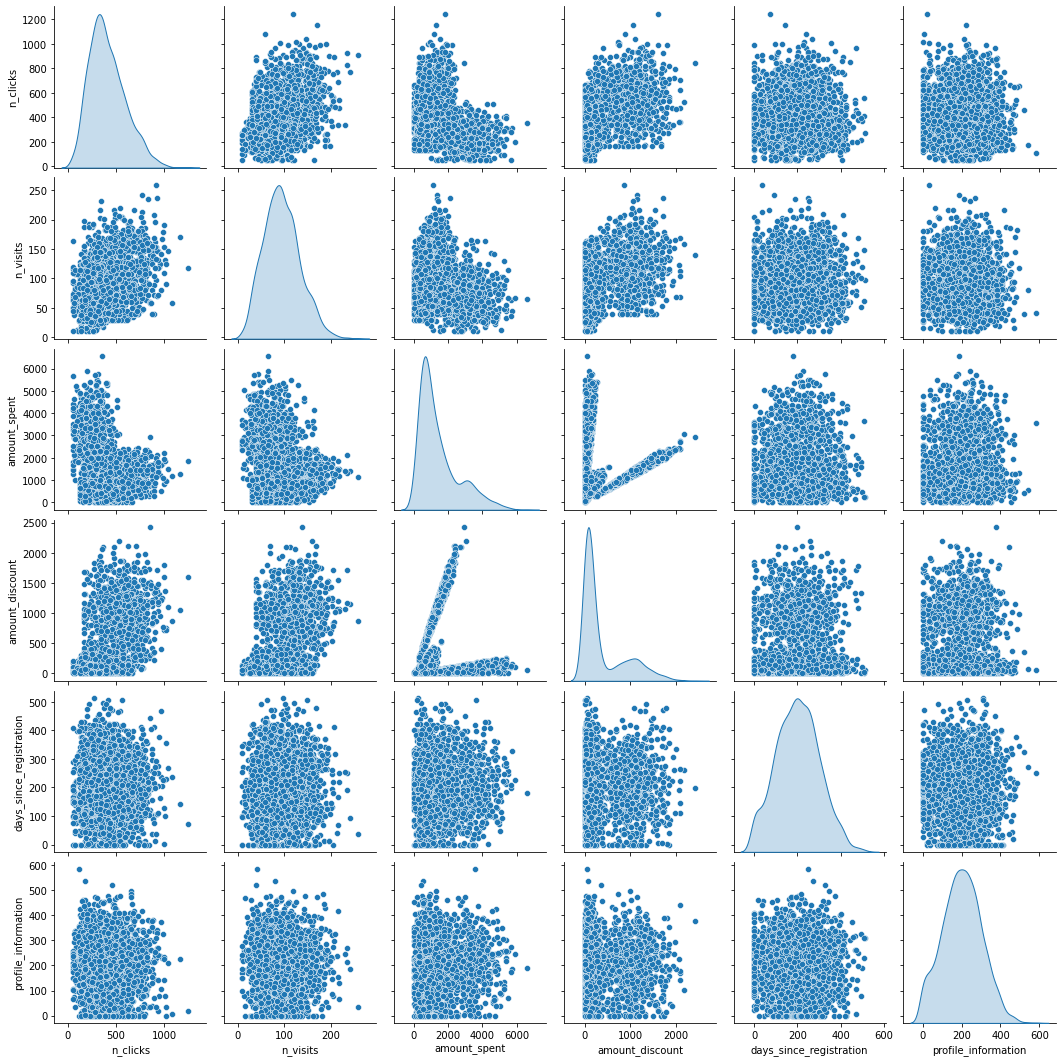

In [4]:
sns.pairplot(df.drop(columns=['ID'], axis=1), diag_kind='kde')

At first glance, we can see most attributes follow a normal distribution, except for "amount_spent" and "amount_discount". We will seperate them into a jointplot for analysis.

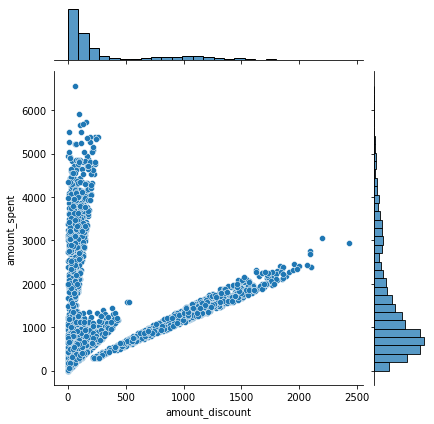

In [5]:
sns.jointplot(y=df['amount_spent'], x=df['amount_discount'])

Looking at the visualization, we can conclude that:
- **amount_spent** has a bell shape with long right tail, which does make sense if sale amount of luxury, expensive products is lower
- Due to the nature of the attributes, **amount_discount** has a mode of 0, and see steep decline at value above 300
- **amount_discount** positively correlate with **amount_spent**, but this correlation is by designed as **amount_discount** is calculated directly using **amount_spent**.

## Implementing Clustering
To make things simple, we first implement clustering based only 2 axis: "n_clicks", and "amount_spent", since the clusters from these 2 features are pretty obvious.

<AxesSubplot:xlabel='amount_spent', ylabel='n_visits'>

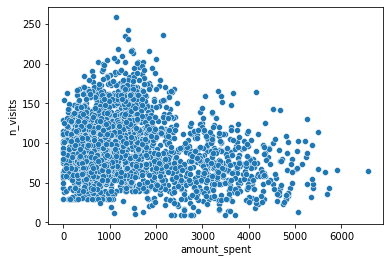

In [6]:
c_df = df.loc[:,["amount_spent","n_visits"]]
sns.scatterplot(x=df['amount_spent'],y=df['n_visits'])

If we use just our human eyes, we can clearly see 2 seperate groups derived from the scatter plot. One with high spending amount but low clicks, and high amount of clicks but low spending amount

# Feature scaling
K-means clustering method functions by minimizing intra-variance between each group, which requires the calculation of distance between each pair of observations. Specifically in this note, we will use **Euclidean distance**.
$d\left( x,y\right)   = \sqrt {\sum _{i=1}^{n}  \left( y_{i}-x_{i}\right)^2 }$

Using this formula, every columns should be normalized, so that the value difference between 2 columns will not skew the result. (amount_spent's values are generally a lot higher than n_visits). Normalization will be performed using min-max scaler.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
scaler.fit(c_df)
X = pd.DataFrame(scaler.transform(c_df))
X.columns = c_df.columns
X


,amount_spent,n_visits
0,0.045680,0.530120
1,0.113261,0.341365
2,0.046543,0.156627
3,0.044339,0.080321
4,0.107065,0.638554
...,...,...
2495,0.506841,0.622490
2496,0.302396,0.064257
2497,0.142662,0.301205
2498,0.061654,0.204819


# Choosing k
As mentioned above, k is a free parameter and have to be chosen, which now raise the question of "What's the optimal number for k?"

We want the amount of cluster to be big enough to minimize the variance within each group, but not too large that it creates artificial boundaries within a group.

## Method
There exist many methods to figure out k:
- Elbow method
- Silhouette method
- Gap statistics

In this note we will use Elbow to determine k. It is easier to explain the method with visualization

<AxesSubplot:xlabel='Clusters', ylabel='Sum of Squared Distances'>

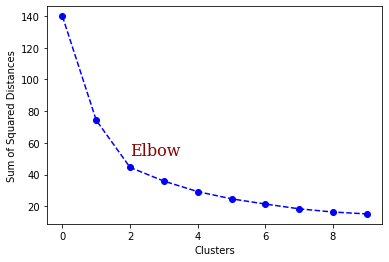

In [8]:

intra_variance=[]
for i in range(1,11):
    km = KMeans(n_clusters=i,
               max_iter=300)
    km.fit(X)
    intra_variance.append(km.inertia_)
intra_variance=pd.Series(intra_variance)

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.ylabel('Sum of Squared Distances')
plt.xlabel('Clusters') 
plt.text(2,intra_variance[2]+5,"Elbow", ha='left',va = "bottom",fontdict=font)
intra_variance.plot(linestyle='--', marker='o', color='b', label='line with marker')

If you can guess, we iterate through a range of k, and determine at what value of k do we stop seeing a huge drop for intra-variance, aka the "elbow".

As shown in the chart, sum of Squared Distance (or intra-variance) see a steep drops, up until **2 clusters**. So, k=2 is our "elbow", and also the optimal amount of cluster. So now we implement k-means on the data with k=2.

<AxesSubplot:xlabel='amount_spent', ylabel='n_visits'>

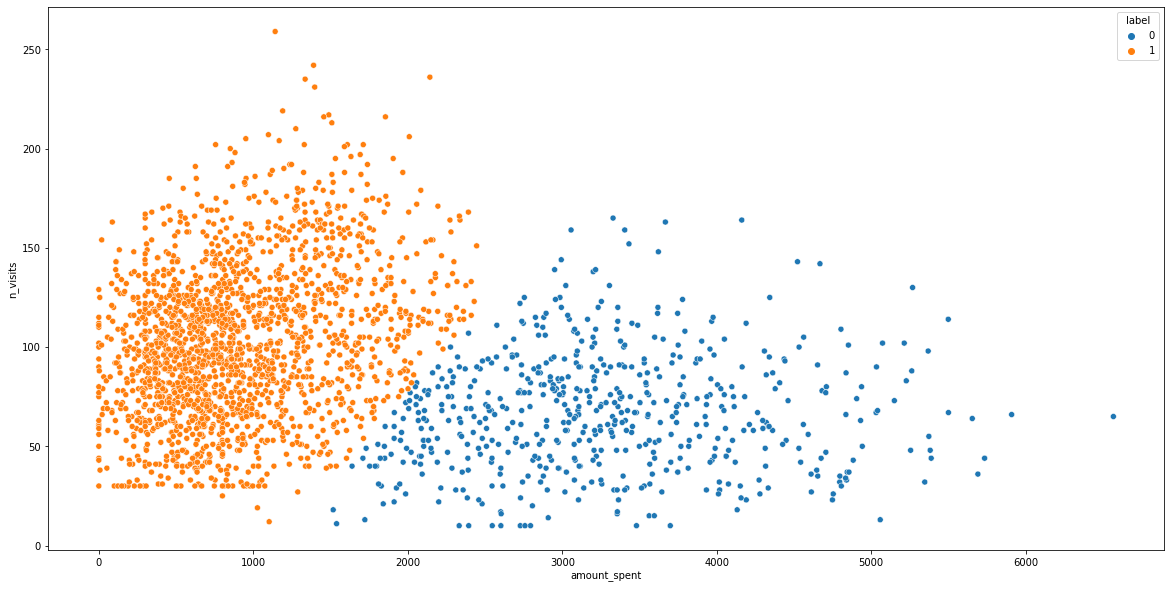

In [15]:
km = KMeans(n_clusters=2,
               max_iter=300)
km.fit(X)
c_df['label'] = km.labels_
plt.figure(figsize=(20,10))
sns.scatterplot(x=c_df['amount_spent'], y=c_df["n_visits"], hue=c_df['label'])